# Building Models for the IMDB Reviews Dataset

## Imports

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Download and Prepare the Dataset

In [2]:
# Download the plain text dataset
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete9B3Y71/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete9B3Y71/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete9B3Y71/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
# Get the train and test sets
train_data, test_data = imdb['train'], imdb['test']

# Initialize senteces and labels lists
training_sentences = []
training_labels =[]

testing_sentences =[]
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf-8'))
  training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf-8'))
  testing_labels.append(l.numpy())

# Convert labels list to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [7]:
# Parameters
vocab_size = 10000
max_length = 120
trunc_type ='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

## Plot Utility

In [8]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

### Model 1: Flatten

In [9]:
# Parameters
embedding_dim = 16
dense_dim = 6

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_flatten.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_flatten.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171533 (670.05 KB)
Trainable params: 171533 (670.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_flatten = model_flatten.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 30s 137ms/step - loss: 0.5969 - accuracy: 0.6749 - val_loss: 0.3850 - val_accuracy: 0.8375
Epoch 2/10
196/196 [==============================] - 14s 70ms/step - loss: 0.3124 - accuracy: 0.8701 - val_loss: 0.3353 - val_accuracy: 0.8540
Epoch 3/10
196/196 [==============================] - 9s 46ms/step - loss: 0.1949 - accuracy: 0.9330 - val_loss: 0.3581 - val_accuracy: 0.8469
Epoch 4/10
196/196 [==============================] - 7s 35ms/step - loss: 0.1050 - accuracy: 0.9740 - val_loss: 0.3945 - val_accuracy: 0.8414
Epoch 5/10
196/196 [==============================] - 5s 28ms/step - loss: 0.0473 - accuracy: 0.9939 - val_loss: 0.4394 - val_accuracy: 0.8383
Epoch 6/10
196/196 [==============================] - 4s 21ms/step - loss: 0.0218 - accuracy: 0.9983 - val_loss: 0.4791 - val_accuracy: 0.8369
Epoch 7/10
196/196 [==============================] - 2s 11ms/step - loss: 0.0111 - accuracy: 0.9995 - val_loss: 0.5180 - val_accuracy: 0.8

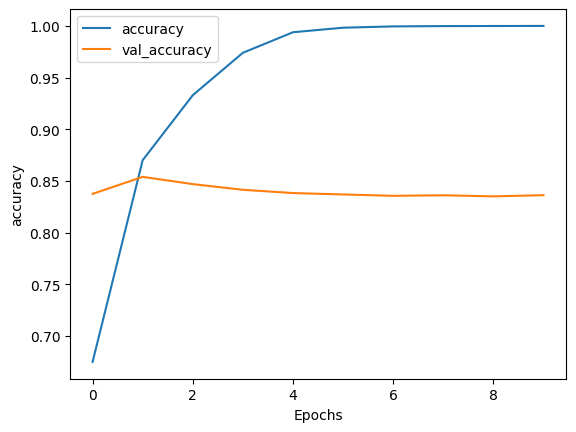

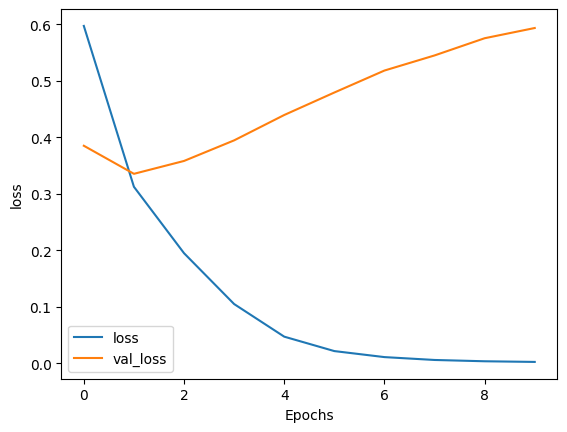

In [11]:
# Plot the accuracy and loss history
plot_graphs(history_flatten, 'accuracy')
plot_graphs(history_flatten, 'loss')

### LSTM

In [12]:
# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirection  (None, 64)                12544     
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172941 (675.55 KB)
Trainable params: 172941 (675.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 24s 100ms/step - loss: 0.5339 - accuracy: 0.7128 - val_loss: 0.3701 - val_accuracy: 0.8386
Epoch 2/10
196/196 [==============================] - 10s 53ms/step - loss: 0.3071 - accuracy: 0.8758 - val_loss: 0.3673 - val_accuracy: 0.8421
Epoch 3/10
196/196 [==============================] - 6s 31ms/step - loss: 0.2390 - accuracy: 0.9090 - val_loss: 0.3817 - val_accuracy: 0.8356
Epoch 4/10
196/196 [==============================] - 7s 38ms/step - loss: 0.2071 - accuracy: 0.9236 - val_loss: 0.3994 - val_accuracy: 0.8327
Epoch 5/10
196/196 [==============================] - 5s 26ms/step - loss: 0.1727 - accuracy: 0.9394 - val_loss: 0.5564 - val_accuracy: 0.8118
Epoch 6/10
196/196 [==============================] - 6s 30ms/step - loss: 0.1499 - accuracy: 0.9476 - val_loss: 0.5057 - val_accuracy: 0.8203
Epoch 7/10
196/196 [==============================] - 4s 21ms/step - loss: 0.1176 - accuracy: 0.9615 - val_loss: 0.5367 - val_accuracy: 0.8

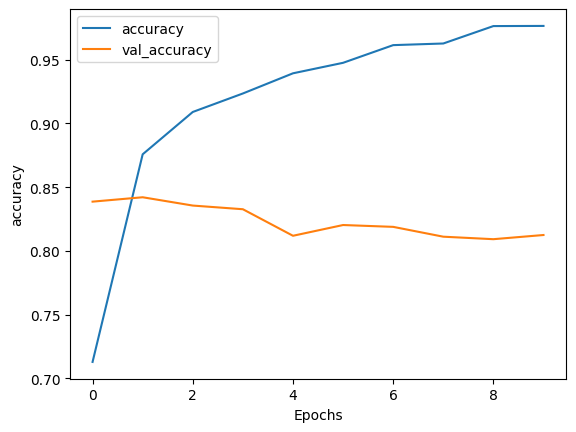

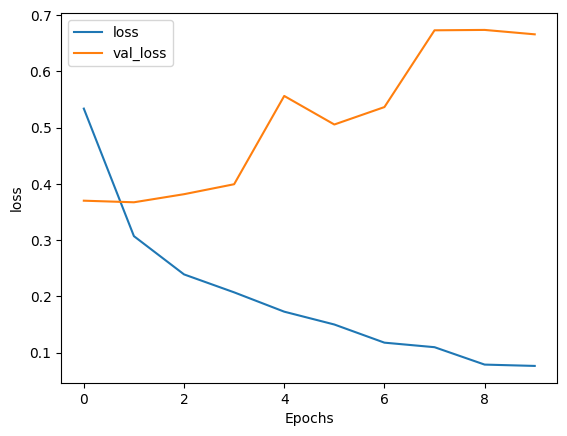

In [14]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

### GRU

In [15]:
import tensorflow as tf

# Parameters
embedding_dim = 16
gru_dim = 32
dense_dim = 6

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                9600      
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169997 (664.05 KB)
Trainable params: 169997 (664.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_gru = model_gru.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 22s 89ms/step - loss: 0.5641 - accuracy: 0.6754 - val_loss: 0.3562 - val_accuracy: 0.8460
Epoch 2/10
196/196 [==============================] - 10s 51ms/step - loss: 0.3117 - accuracy: 0.8729 - val_loss: 0.3376 - val_accuracy: 0.8534
Epoch 3/10
196/196 [==============================] - 6s 33ms/step - loss: 0.2361 - accuracy: 0.9116 - val_loss: 0.3718 - val_accuracy: 0.8457
Epoch 4/10
196/196 [==============================] - 6s 32ms/step - loss: 0.1921 - accuracy: 0.9316 - val_loss: 0.4288 - val_accuracy: 0.8412
Epoch 5/10
196/196 [==============================] - 5s 28ms/step - loss: 0.1541 - accuracy: 0.9468 - val_loss: 0.4665 - val_accuracy: 0.8343
Epoch 6/10
196/196 [==============================] - 5s 23ms/step - loss: 0.1246 - accuracy: 0.9579 - val_loss: 0.5062 - val_accuracy: 0.8274
Epoch 7/10
196/196 [==============================] - 4s 20ms/step - loss: 0.1003 - accuracy: 0.9679 - val_loss: 0.5922 - val_accuracy: 0.82

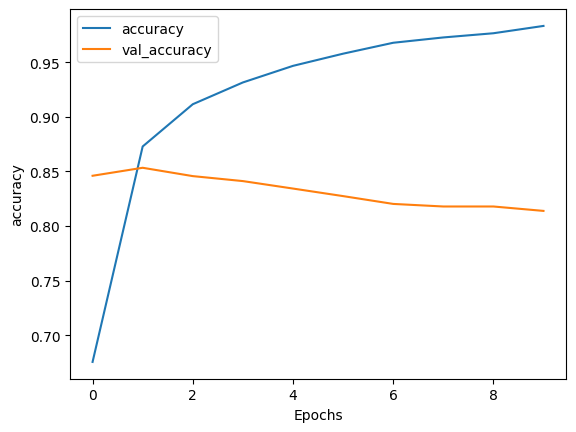

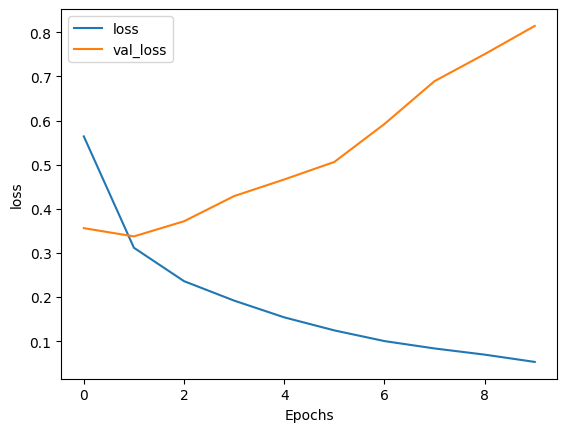

In [17]:
# Plot the accuracy and loss history
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')

### Convolution

In [18]:
# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_6 (Dense)             (None, 6)                 774       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171149 (668.55 KB)
Trainable params: 171149 (668.55 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [19]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_conv = model_conv.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 18s 77ms/step - loss: 0.5415 - accuracy: 0.7003 - val_loss: 0.3602 - val_accuracy: 0.8424
Epoch 2/10
196/196 [==============================] - 7s 35ms/step - loss: 0.2977 - accuracy: 0.8774 - val_loss: 0.3450 - val_accuracy: 0.8513
Epoch 3/10
196/196 [==============================] - 6s 30ms/step - loss: 0.2380 - accuracy: 0.9055 - val_loss: 0.3796 - val_accuracy: 0.8410
Epoch 4/10
196/196 [==============================] - 4s 20ms/step - loss: 0.2037 - accuracy: 0.9232 - val_loss: 0.4157 - val_accuracy: 0.8338
Epoch 5/10
196/196 [==============================] - 3s 14ms/step - loss: 0.1761 - accuracy: 0.9353 - val_loss: 0.4489 - val_accuracy: 0.8301
Epoch 6/10
196/196 [==============================] - 2s 12ms/step - loss: 0.1555 - accuracy: 0.9462 - val_loss: 0.4995 - val_accuracy: 0.8233
Epoch 7/10
196/196 [==============================] - 3s 13ms/step - loss: 0.1355 - accuracy: 0.9542 - val_loss: 0.5555 - val_accuracy: 0.820

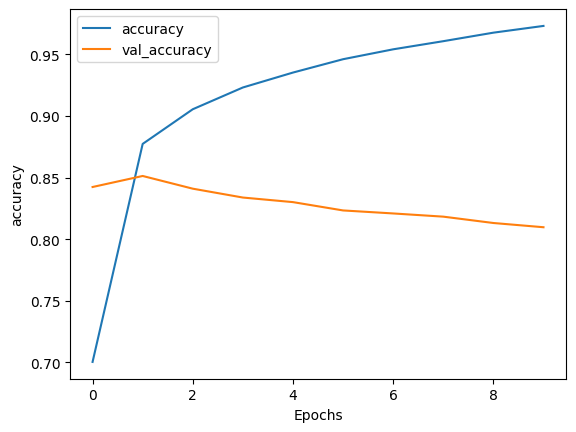

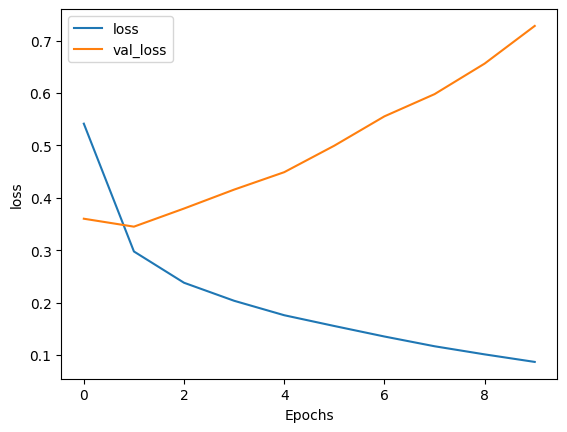

In [20]:
# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')